In [57]:
import pandas as pd

In [58]:
def readFileAsArr(fileName, source):
    res = []
    file = open('/home/brgverst/benchres/' + fileName, encoding="utf8").read()
    for ind, line in enumerate(file.split('\n')):
        if line == '':
            continue
        splitLine = line.split(",")
        res.append([source, splitLine[0], splitLine[1], float(splitLine[2])])
    return res

latencies = readFileAsArr('plumber.txt', 'Plumber')
latencies = latencies + readFileAsArr('baseline.txt', 'Baseline')
latencies = latencies + readFileAsArr('dapr.txt', 'Dapr')

In [59]:
df = pd.DataFrame(latencies, columns=['Platform', 'Begin nano', 'End nano', 'latency (ms)'])

In [60]:
df.groupby(["Platform"]).describe()


latency (ms)                                                    \
                count      mean       std       min       25%       50%   
Platform                                                                  
Baseline      10000.0  2.430956  2.814151  1.510714  2.068306  2.232447   
Dapr          10000.0  2.737769  2.978431  1.774615  2.328618  2.503373   
Plumber       10000.0  2.955402  2.986927  1.889260  2.543147  2.711383   

                                
               75%         max  
Platform                        
Baseline  2.412019  113.258154  
Dapr      2.701999  113.168914  
Plumber   2.918012  114.599235

In [61]:
df.head()

,Platform,Begin nano,End nano,latency (ms)
0,Plumber,1628614147200402790,1628614147203842212,3.439422
1,Plumber,1628614147301685014,1628614147304552938,2.867924
2,Plumber,1628614147402560774,1628614147405345547,2.784773
3,Plumber,1628614147503372655,1628614147506202148,2.829493
4,Plumber,1628614147604428759,1628614147607238117,2.809358


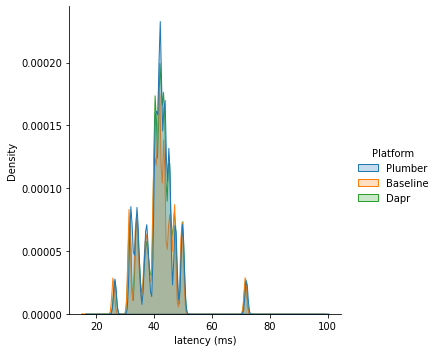

In [62]:
sns.displot(df, x="latency (ms)", hue="Platform", kind="kde", fill=True, cut=-30)